In [1]:
from exojax.atm import amclouds
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from exojax.spec import rtransfer as rt
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP,logPtop=-8.,logPbtm=4.0)
alpha=0.097
T0=1200.
Tarr=T0*(Parr)**alpha

ERROR:MainThread:vaex:issue loading plot
Traceback (most recent call last):
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/vaex_core-4.3.0.post1-py3.7-linux-x86_64.egg/vaex/__init__.py", line 754, in <module>
    add_namespace = entry.load()
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2453, in load
    return self.resolve()
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2459, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
ModuleNotFoundError: No module named 'vaex.viz'
ERROR:MainThread:vaex:issue loading astro
Traceback (most recent call last):
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/vaex_core-4.3.0.post1-py3.7-linux-x86_64.egg/vaex/__init__.py", line 754, in <module>
    add_namespace = entry.load()
  File "/home/kawahara/anaconda3/lib/python3.7/site-packages/pkg_resources/__init__.py", line 2453, in load
    return s

In [3]:
n={}
n["Mg"]=3.7e-5
n["Si"]=3.e-5
n["O"]=4.5e-4
n["Fe"]=2.9e-5

VMR_enstatite=np.min([n["Mg"],n["Si"],n["O"]/3])
VMR_Fe=n["Fe"]

In [4]:
#from exojax.atm.psat import Psat_enstatite

def Psat_enstatite(T):
    """Saturation Vapor Pressure for Enstatite (MgSiO3)                         
                                                                                
    Note:                                                                       
       Taken from Ackerman and Marley 2001 Appendix A (A4) see also their errat\
a.                                                                              
                                                                                
    Args:                                                                       
       T: temperature (K)                                                       
                                                                                
    Returns:                                                                    
       saturation vapor pressure (bar)                                          
                                                                                
    """
    return jnp.exp(25.37-58663./T)

P_enstatite=Psat_enstatite(Tarr)

def Psat_Fe_solid(T):
    return jnp.exp(15.71-47664./T)
P_fe_sol=Psat_Fe_solid(Tarr)


#def Psat_Fe_liquid(T):
#    return jnp.exp(9.86-37120./T)
#
#P_fe_liq=Psat_Fe_liquid(Tarr)


In [5]:
# from Virga
#def Psat_enstatite_new(T):
#    return 10.0**(11.83 - 27250.0/T - 1.0)
#P_enstatite_new=Psat_enstatite_new(Tarr)

In [64]:
from jax import jit
@jit
def get_Pbase(Parr,Psat,VMR):
    """Pbase
    Args:
        Parr: pressure array
        Psat: saturation pressure arrau
        VMR: VMR for vapor
        
    Returns:
        Pbase: base pressure
    """
    #ibase=jnp.searchsorted((Psat/VMR)-Parr,0.0) # 231 +- 9.2 us
    ibase=jnp.argmin(jnp.abs(jnp.log(Parr)-jnp.log(Psat)+jnp.log(VMR))) # 73.8 +- 2.9 us
    return Parr[ibase]

In [65]:
Pbase_enstatite=get_Pbase(Parr,P_enstatite,VMR_enstatite)
Pbase_Fe_sol=get_Pbase(Parr,P_fe_sol,VMR_Fe)

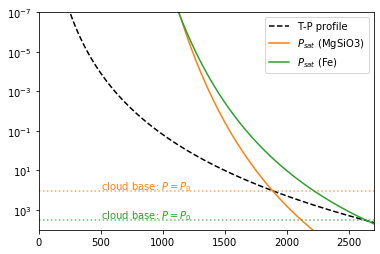

In [67]:
import matplotlib.pyplot as plt
plt.plot(Tarr,Parr,color="black",ls="dashed",label="T-P profile")
plt.plot(Tarr,P_enstatite/VMR_enstatite,label="$P_{sat}$ (MgSiO3)",color="C1")
plt.axhline(Pbase_enstatite,color="C1",alpha=0.7,ls="dotted")
plt.text(500,Pbase_enstatite*0.8,"cloud base: $P=P_0$",color="C1")

plt.plot(Tarr,P_fe_sol/VMR_Fe,label="$P_{sat}$ (Fe)",color="C2")
plt.axhline(Pbase_Fe_sol,color="C2",alpha=0.7,ls="dotted")
plt.text(500,Pbase_Fe_sol*0.8,"cloud base: $P=P_0$",color="C2")

plt.yscale("log")
plt.ylim(10000,1.e-7)
plt.xlim(0,2700)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [68]:
from jax import vmap
def VMRcloud(P,Pbase,fsed,VMRbase,kc=1):
    """VMR of clouds based on AM01
    
    Args:
        P: Pressure (bar)
        Pbase: base pressure (bar)
        fsed: fsed
        VMRbase: VMR of condensate at cloud base
        kc: constant ratio of condenstates to total mixing ratio
        
    Returns:
        VMR of condensates
        
    """
    VMRc=jnp.where(Pbase>P,VMRbase*(P/Pbase)**(fsed/kc),0.0)
    return VMRc

get_VMRc=vmap(VMRcloud,(0,None,None,None),0)

In [69]:
from jax import vmap
fsed=3
VMRbase_enstatite=VMR_enstatite
VMRc_enstatite=get_VMRc(Parr,Pbase_enstatite,fsed,VMR_enstatite)

VMRbase_Fe=VMR_Fe
VMRc_Fe=get_VMRc(Parr,Pbase_Fe_sol,fsed,VMR_Fe)

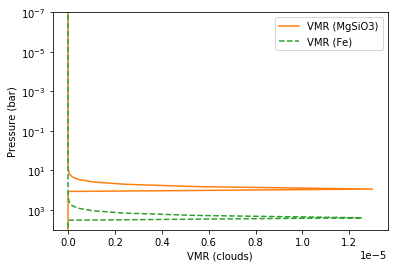

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3,3])
plt.plot(VMRc_enstatite,Parr,color="C1",label="VMR (MgSiO3)")
plt.plot(VMRc_Fe,Parr,color="C2",ls="dashed",label="VMR (Fe)")

plt.yscale("log")
plt.ylim(10000,1.e-7)
#plt.xlim(0,2700)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("VMR (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("vmrcloud.png")
plt.show()

In [95]:
def vf_stokes(r,g,eta,drho,Nkn=0.):
    """terminal velocity of Stokes flow (Reynolds number << 1)
    
    Args:
        r: particle size
        g: gravity
        eta: dynamic viscosity
        drho: density difference between condensates and atmosphere (g/cm3)
        Nkn: Knudsen number
        
    Note:
        (1.0+1.255*Nkn) is the Cunningham factor
    
    Return:
        terminal velocity
        
    """
    return 2.0*g*r*r*drho*(1.0+1.255*Nkn)/(9.0*eta)

In [140]:
# dynamic viscosity in H2 atmosphere (cm/g/s)
from exojax.atm.viscosity import eta_Rosner,calc_vfactor
T=np.logspace(np.log10(1000),np.log10(2000))
vfactor,Tr=calc_vfactor("H2")
eta=eta_Rosner(T,vfactor)

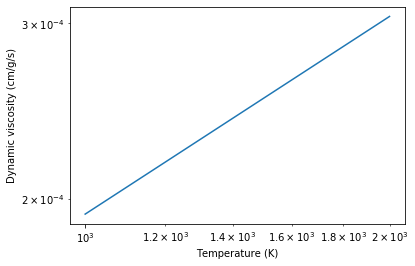

In [141]:
plt.plot(T,eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

In [87]:
from scipy.constants import k as kB #kg m2/s2/K
from scipy.constants import m_u #kg
#fac=kB/m_u*1.e4 #cgs cm2/s2/K

from exojax.utils.constants import kB
from exojax.utils.constants import m_u

def Hatm(g,T,mu):
    """pressure scale height assuming an isothermal atmosphere
    
    Args:
        g: gravity acceleration (cm/s2)
        T: isothermal temperature (K)
        mu: mean molecular weight
        
    Returns:
        pressure scale height (cm)
    
    """
    
    return kB*T/(m_u*mu*g)

In [88]:
Hatm(1.e5,1000.,2)

415722.9931793715

In [96]:
rhoc_enstatite=3.192 #g/cm3 Lodders and Fegley (1998)
rhoc_Fe=7.875

from exojax.spec.molinfo import molmass
mu=molmass("H2")
muc_enstatite=molmass("MgSiO3")
muc_Fe=molmass("Fe")

In [93]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
#from exojax.atm.amclouds import vf_stokes
vfactor, trange=calc_vfactor(atm="H2")
eta_fid=eta_Rosner(1700.0,vfactor)
g=1.e5
rarr=jnp.logspace(-6,-4,40) #cm

drho=
vfs=vf_stokes(rarr,g,eta_fid,drho,Nkn=0.0)

Kzz=1.e5 #cm2/s
sigmag=2.0
alphav=1.3
mu=2.0
L=Hatm(g,1500,mu)

In [94]:
Kzz/L

0.160363193184992

Text(0.5, 0, 'condensate size (cm)')

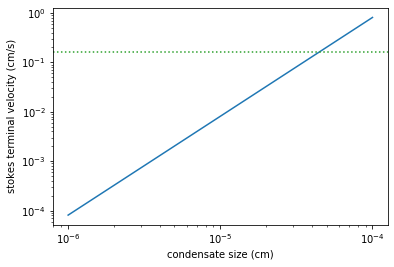

In [145]:
plt.plot(rarr,vfs)
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz/L,label="Kzz/H",color="C2",ls="dotted")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")

In [146]:
iscale=jnp.searchsorted(vfs,Kzz/L)
rw=rarr[iscale]

In [147]:
rw

DeviceArray(4.92388e-05, dtype=float32)

In [148]:
def get_rg(rw,fsed,alpha,sigmag):
    
    rg=rw*fsed**(1.0/alpha)*jnp.exp(-(alpha/2.0+3.0)*(jnp.log(sigmag))**2)
    return rg
    

In [149]:
rg=get_rg(rw,fsed,alphav,sigmag)
rg

DeviceArray(1.9848228e-05, dtype=float32)

In [151]:
def dtau_cloudgeo(Parr,muc,rhoc,mu,VMRc,rg,sigmag,g):
    fac=jnp.exp(-2.5*jnp.log(sigmag)**2)
    dtau=1.5*muc/mu*VMRc*fac/(rg*rhoc*g)*Parr*1.e6
    return dtau

In [152]:
dtau_enstatite=dtau_cloudgeo(Parr,muc_enstatite,rhoc_enstatite,mu,VMRc_enstatite,rg,sigmag,g)
dtau_Fe=dtau_cloudgeo(Parr,muc_Fe,rhoc_Fe,mu,VMRc_Fe,rg,sigmag,g)

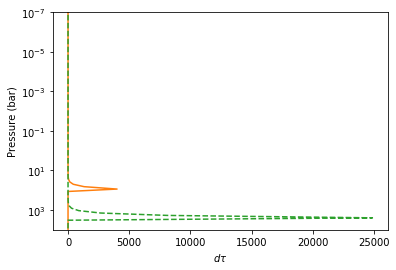

In [153]:
plt.plot(dtau_enstatite,Parr,color="C1")
plt.plot(dtau_Fe,Parr,color="C2",ls="dashed")
plt.yscale("log")
plt.ylim(10000,1.e-7)
plt.xlabel("$d\\tau$")
plt.ylabel("Pressure (bar)")
#plt.xscale("log")
plt.gca().invert_yaxis()

In [154]:
#CIA
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(9500,30000,1000,unit="AA")
from exojax.spec import contdb
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

nugrid is log: mode= lpf
H2-H2


In [155]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

In [156]:
dtau=dtaucH2H2+dtau_enstatite[:,None]+dtau_Fe[:,None]

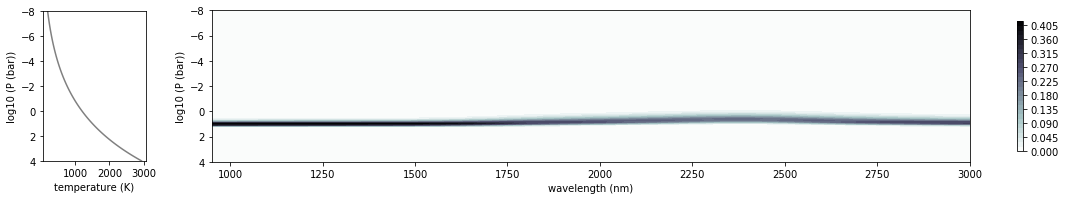

In [157]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr,unit="nm")
plt.show()

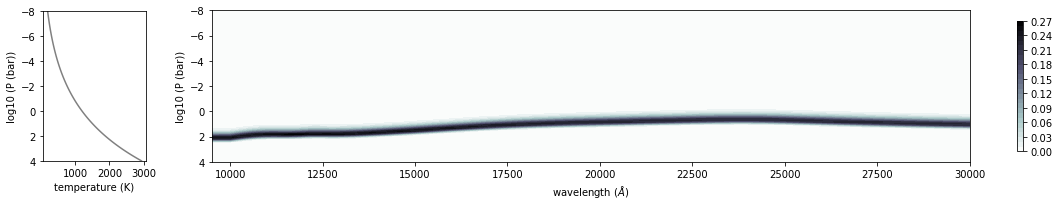

In [158]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtaucH2H2,Tarr,Parr,dParr,unit="AA")
plt.show()

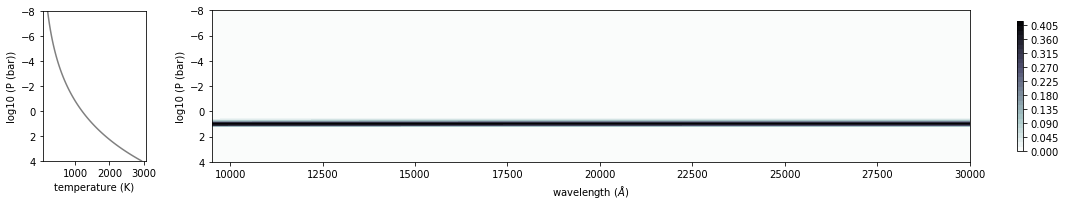

In [159]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau_enstatite[:,None]+np.zeros_like(dtaucH2H2),Tarr,Parr,dParr,unit="AA")
plt.show()

In [160]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)
F0CIA=rtrun(dtaucH2H2,sourcef)
F0cl=rtrun(dtau_enstatite[:,None]+np.zeros_like(dtaucH2H2),sourcef)

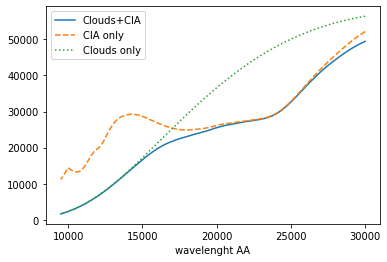

In [163]:
plt.plot(wav[::-1],F0,label="Clouds+CIA")
plt.plot(wav[::-1],F0CIA,label="CIA only",ls="dashed")
plt.plot(wav[::-1],F0cl,label="Clouds only",ls="dotted")
plt.xlabel("wavelenght AA")
plt.legend()
plt.show()